In [1]:
import syft as sy

# Part 1: Join the Duet Server the Data Owner connected to

In [2]:
duet = sy.join_duet(loopback=True)

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > CONNECTED!


### <img src="https://github.com/OpenMined/design-assets/raw/master/logos/OM/mark-primary-light.png" alt="he-black-box" width="100"/> Checkpoint 0 : Now STOP and run the Data Owner notebook until Checkpoint 1.

# Part 2: Search for Available Data


In [3]:
# The data scientist can check the list of searchable data in Data Owner's duet store
duet.store.pandas

,ID,Tags,Description,object_type
0,<UID: 5cb957a9c62342139256f9aeb73b39f0>,[Loan-data],This is a train dataset for Credit Default cla...,<class 'torch.Tensor'>
1,<UID: ce5bd4bc2dee4d0aa03d877ce6e3da3e>,[Loan-target],"Labels for Defaulted: No, Yes",<class 'torch.Tensor'>


Data Scientist wants to use the Bank dataset. (S)He needs a pointer to the data and
a pointer to the target for prediction.

In [4]:
data_ptr = duet.store[0]
target_ptr = duet.store[1]

`data_ptr` is a reference to the iris dataset remotely available on data owner's server.
`target_ptr` is a reference to the iris dataset LABELS remotely available on data owner's server

In [5]:
print(data_ptr)
print(target_ptr)

# Part 3: Perform Logistic Regression on Bank dataset
Now the data scientist can perform machine learning on the data that is in the Data Owner's duet server, without the owner having to share his/her data.

### Basic analysis

First the data scientist needs to know some basic information about the dataset.
1. The length of the dataset
2. The input dimension
3. The output dimension

These information have to be explicitly shared by the Data Owner. Let's try to find them in the data description.

In [6]:
print(duet.store.pandas["Description"][0])
print()
print(duet.store.pandas["Description"][1])

This is a train dataset for Credit Default classification.

Labels for Defaulted: No, Yes


### Train model

In [7]:
import pandas as pd
import numpy as np
import csv
from random import seed
from csv import reader 
import torch

In [8]:
in_dim = 71
out_dim = 2
n_samples = 8360

First, let's create our model for `Logistic Regression`. If you are already familiar with PyTorch, you will notice that the model is built almost the exact same way as you do in PyTorch. The main difference is that here we inherit from `sy.Module` instead of `nn.Module`. We also need to pass in a variable called `torch_ref` which we will use internally for any calls that you would normally make to torch.

In [9]:
class SyNet(sy.Module):
    def __init__(self, torch_ref):
        super(SyNet, self).__init__(torch_ref=torch_ref)
        self.layer1 = self.torch_ref.nn.Linear(in_dim, 100)
        self.layer2 = self.torch_ref.nn.Linear(100, 100)
        self.out = self.torch_ref.nn.Linear(100, out_dim)

    def forward(self, x):
        x = self.torch_ref.nn.functional.relu(self.layer1(x))
        x = self.torch_ref.nn.functional.relu(self.layer2(x))
        output = self.torch_ref.nn.functional.log_softmax(self.out(x), dim=1)
        return output


Now we can create a local model by passing our local copy of torch.

In [10]:
local_model = SyNet(torch)

Now we will send the local copy of the model to our partner's duet server.

In [11]:
remote_model = local_model.send(duet)

Let's create an alias for our partner’s torch called `remote_torch` so we can refer to the local torch as torch and any operation we want to do remotely as `remote_torch`. Remember, the return values from `remote_torch` are Pointers, not the real objects. They mostly act the same when using them with other Pointers but they cannot be mixed with local torch objects.

In [12]:
remote_torch = duet.torch

We will get a pointer to our remote model parameters. Then we will set our optimizer. Here, we will be using `Adam optimizer`. `params` is a pointer to the list of parameters. `optim` is a reference to the Adam optimizer which can be used to optimize the remote model.

In [13]:
params = remote_model.parameters()
optim = remote_torch.optim.Adam(params=params, lr=0.01)
print("params:", params)
print("optim:", optim)

params: <syft.proxy.syft.lib.python.ListPointer object at 0x0000019008752CD0>
optim: <syft.proxy.torch.optim.AdamPointer object at 0x000001900831FA30>


Now we will create our `train` function. It will take few parameters, like the `remote_model`, `torch_ref`, `optim` and `data_ptr` and `target_ptr`.

In [15]:
def train(iterations, model, torch_ref, optim, data_ptr, target_ptr):

    losses = []

    for i in range(iterations):

        optim.zero_grad()

        output = model(data_ptr)

        # nll_loss = negative log-liklihood loss
        loss = torch_ref.nn.functional.nll_loss(output, target_ptr.long())

        loss_item = loss.item()

        loss_value = loss_item.get(
            reason="To evaluate training progress", request_block=True, timeout_secs=5
        )

        if i % 10 == 0:
            print("Epoch", i, "loss", loss_value)

        losses.append(loss_value)

        loss.backward()

        optim.step()

    return losses

In [20]:
iteration = 300
losses = train(iteration, remote_model, remote_torch, optim, data_ptr, target_ptr)

Epoch 0 loss 0.24264490604400635
Epoch 10 loss 0.23889362812042236
Epoch 20 loss 0.23545600473880768
Epoch 30 loss 0.23228685557842255
Epoch 40 loss 0.22932256758213043
Epoch 50 loss 0.2379290759563446
Epoch 60 loss 0.710316002368927
Epoch 70 loss 0.4474920928478241
Epoch 80 loss 0.4065604507923126
Epoch 90 loss 0.3138148784637451
Epoch 100 loss 0.2606933116912842
Epoch 110 loss 0.23669233918190002
Epoch 120 loss 0.23380990326404572
Epoch 130 loss 0.22910615801811218
Epoch 140 loss 0.22571298480033875
Epoch 150 loss 0.22313348948955536
Epoch 160 loss 0.22098924219608307
Epoch 170 loss 0.21893109381198883
Epoch 180 loss 0.21699558198451996
Epoch 190 loss 0.21514131128787994
Epoch 200 loss 0.21337071061134338
Epoch 210 loss 0.21333768963813782
Epoch 220 loss 0.35378319025039673
Epoch 230 loss 0.4522413909435272
Epoch 240 loss 0.3984851837158203
Epoch 250 loss 0.2624441385269165
Epoch 260 loss 0.2402951568365097
Epoch 270 loss 0.22255383431911469
Epoch 280 loss 0.21823063492774963
Epoch 2

In [21]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'iteration')

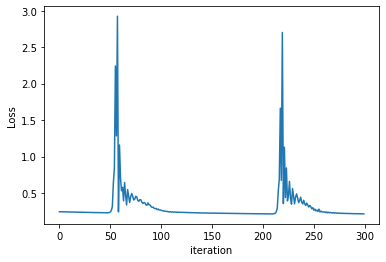

In [22]:
plt.plot(range(iteration), losses)
plt.ylabel("Loss")
plt.xlabel("iteration")

### Download model

In [23]:
def get_local_model(model):
    if not model.is_local:
        local_model = model.get(
            request_block=True,
            reason="To run test and inference locally",
            timeout_secs=5,
        )
    else:
        local_model = model

    return local_model


local_model = get_local_model(remote_model)

### Test on local data

In [24]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [25]:
project_test = pd.read_csv("C:/Data Science and Analytics/DSA 5900/Final Deliverable/Test.csv")
project_test.drop(['Unnamed: 0'] , axis = 1, inplace =True)

project_test = project_test.dropna()
project_test.head()

,VerificationType,LanguageCode,Age,Gender,AppliedAmount,Amount,Interest,LoanDuration,MonthlyPayment,UseOfLoan,...,Rating_F,Rating_HR,Rating_nan,Status_Late,Status_Repaid,Status_nan,Restructured_True,Restructured_nan,diff_days,Defaulted
0,4.0,1,0.442308,1.0,0.292715,0.292715,0.061933,0.282051,0.056659,2,...,0,0,0,0,1,0,0,0,1125.0,1
1,4.0,1,0.576923,1.0,0.414284,0.414284,0.140012,1.000000,0.065239,9,...,0,0,0,1,0,0,0,0,3639.0,1
2,4.0,3,0.442308,1.0,0.192136,0.192136,0.076600,0.487179,0.028883,9,...,0,0,0,0,1,0,0,0,1820.0,1
3,4.0,6,0.519231,2.0,0.141229,0.141229,0.197744,0.487179,0.036761,9,...,1,0,0,0,1,0,0,0,125.0,0
4,4.0,4,0.346154,0.0,0.039415,0.039415,0.053530,0.487179,0.005704,9,...,0,0,0,0,0,0,0,0,1819.0,0


In [26]:
X_test = project_test.loc[:, project_test.columns != "Defaulted"]
y_test = project_test["Defaulted"]



In [27]:
X_test = torch.FloatTensor(np.array(X_test))
y_test = torch.LongTensor(np.array(y_test))

In [28]:
preds = []
preds1 = []
with torch.no_grad():
    for i in range(len(X_test)):
        sample = X_test[i]
        y_hat = local_model(sample.unsqueeze(0))
        preds1.append(y_hat)
        pred = y_hat.argmax().item()
        #print(f"Prediction: {pred} Ground Truth: {y_test[i]}")
        preds.append(pred)

In [29]:
acc = accuracy_score(y_test, preds)
print("Overall test accuracy", acc * 100)

Overall test accuracy 90.7177033492823


In [42]:
type(preds[0])

int

In [32]:
# the below code converts the log_softmax to softmax to estimate probabilities of the +ve and the -ve classes

probs = []

for i in range(len(preds1)):
    probs.append(torch.exp(preds1[i]))

In [33]:
probs

[tensor([[0.6000, 0.4000]]),
 tensor([[0.5050, 0.4950]]),
 tensor([[0.9608, 0.0392]]),
 tensor([[1.0000e+00, 7.6565e-07]]),
 tensor([[0.9934, 0.0066]]),
 tensor([[0.6822, 0.3178]]),
 tensor([[0.9710, 0.0290]]),
 tensor([[0.1711, 0.8289]]),
 tensor([[0.9715, 0.0285]]),
 tensor([[0.9888, 0.0112]]),
 tensor([[0.8225, 0.1775]]),
 tensor([[0.9968, 0.0032]]),
 tensor([[0.9920, 0.0080]]),
 tensor([[0.0900, 0.9100]]),
 tensor([[0.1087, 0.8913]]),
 tensor([[0.9883, 0.0117]]),
 tensor([[0.9654, 0.0346]]),
 tensor([[0.9900, 0.0100]]),
 tensor([[0.9981, 0.0019]]),
 tensor([[0.9845, 0.0155]]),
 tensor([[0.1195, 0.8805]]),
 tensor([[0.0171, 0.9829]]),
 tensor([[0.8905, 0.1095]]),
 tensor([[0.9511, 0.0489]]),
 tensor([[0.9983, 0.0017]]),
 tensor([[0.1533, 0.8467]]),
 tensor([[0.9976, 0.0024]]),
 tensor([[0.8257, 0.1743]]),
 tensor([[0.0047, 0.9953]]),
 tensor([[0.4573, 0.5427]]),
 tensor([[0.3752, 0.6248]]),
 tensor([[0.9914, 0.0086]]),
 tensor([[0.4657, 0.5343]]),
 tensor([[0.0263, 0.9737]]),
 tenso

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay

In [35]:
precision1 = precision_score(y_test, preds)
recall1 = recall_score(y_test, preds)
F1_score = f1_score(y_test, preds)
confusion_mat_test = confusion_matrix(y_test, preds)

In [36]:
precision1

0.8649386084583902

In [37]:
recall1

0.869684499314129

In [38]:
F1_score

0.8673050615595076

In [39]:
confusion_mat_test

array([[1262,   99],
       [  95,  634]], dtype=int64)

In [47]:
result = []
for i in range (len(probs)):
    result.append(probs[i].numpy())

result[0]    

array([[0.5999697, 0.4000303]], dtype=float32)

In [51]:
result[0][0][0]

0.5999697

In [60]:
# the below code finds the probability for the positive class
resultprobs =[]
for i in range(len(result)):
    resultprobs.append(result[i][0][1])

In [61]:
auc= roc_auc_score(y_test, resultprobs)

In [62]:
auc

0.9664875641145813

In [64]:
from sklearn.metrics import roc_curve, auc

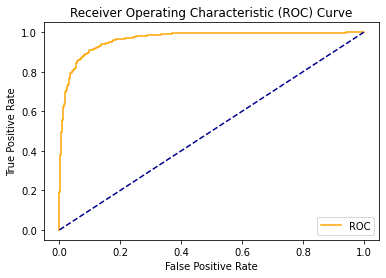

In [65]:
def plot_roc_curve(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
fper, tper, thresholds = roc_curve(y_test, resultprobs) 
plot_roc_curve(fper, tper)